# Compustat World Firms Industry Classification

##  Import Libraries and Load Datasets

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

comp_global = pd.read_csv('../data/compustat_global.csv')
comp_us = pd.read_csv('../data/compustat_north_america.csv')

#comp_global.shape, comp_us.shape

## Initial Data Cleaning

In [58]:
# Limit time frame of interest to be after year 2000.
comp_global = comp_global[(comp_global["fyearq"]>=2000)]
comp_us = comp_us[(comp_us["fyearq"]>=2000)]

#comp_global.shape, comp_us.shape

In [59]:
# Drop columns w/ no predictive power (name) and unaligned columns.
comp_global.drop(['sic','ggroup','gind','gsubind',
                  'conm','conml','datadate','unnpq'], 
                 axis=1, inplace=True)
comp_us.drop(['indfmt','consol','popsrc','datafmt','tic','costat',
              'sic','ggroup','gind','gsubind','datacqtr',
                'conm','conml','datadate','xrdq','niq'], 
                 axis=1, inplace=True)

### Preliminary feature engineering (from domain knowledge)

In [60]:
# Fiscal Period
comp_global['datafqtr'] = comp_global['fyearq'].astype(str)\
                                +'Q' + comp_global['fqtr'].astype(str)
comp_global = comp_global.sort_values('datafqtr')
sorted_unique_periods = sorted(comp_global['datafqtr'].unique())
#comp_global.drop(['fyearq','fqtr'], axis=1, inplace=True)

In [61]:
# Fill Comp Global Currency with USD
comp_global['curcdq'] = None
comp_global['curcdq'].fillna('USD', inplace=True)

In [62]:
# Gross Profit = Sales - Cost of Goods Sold
comp_us['gpq'] = comp_us['saleq'] - comp_us['cogsq']

### Combina Global and US Datasets

In [63]:
comp_global = comp_global[comp_us.columns]
compustat = pd.concat([comp_global, comp_us], ignore_index=True)

ordered_cols = ['gsector','datafqtr','fyearq','fqtr', # response var and time
                'gvkey','loc','exchg','curcdq', # constant variables
                'saleq','gpq','oiadpq','oibdpq', # revenue / profit related variables
                'cogsq','xoprq', # cost related variables
                'atq','seqq','dlcq','dlttq','capxy','oancfy' # asset, debts, cashflow etc.
                ]
compustat = compustat[ordered_cols]
compustat = compustat.sort_values(['gvkey','datafqtr'])
compustat = compustat.reset_index(drop=True)

In [64]:
# Sector
gic_to_sector = {
    0: 'Energy',
    1: 'Materials',
    2: 'Industrials',
    3: 'Consumer Discretionary',
    4: 'Consumer Staples',
    5: 'Health Care',
    6: 'Financials',
    7: 'Information Technology',
    8: 'Communication Services',
    9: 'Utilities',
    10: 'Real Estate'
}
compustat['gsector_num'] = compustat['gsector']/5-2
compustat['gsector'] = compustat['gsector_num'].map(gic_to_sector)

In [65]:
compustat.isna().mean().round(3) * 100

gsector         7.3
datafqtr        0.0
fyearq          0.0
fqtr            0.0
gvkey           0.0
loc             0.0
exchg           0.5
curcdq          0.0
saleq          30.4
gpq            29.4
oiadpq         36.7
oibdpq         31.8
cogsq          31.7
xoprq          28.0
atq            15.0
seqq           11.5
dlcq           30.0
dlttq          31.8
capxy          33.4
oancfy         28.6
gsector_num     7.3
dtype: float64

In [66]:
compustat.head()

,gsector,datafqtr,fyearq,fqtr,gvkey,loc,exchg,curcdq,saleq,gpq,...,oibdpq,cogsq,xoprq,atq,seqq,dlcq,dlttq,capxy,oancfy,gsector_num
0,Industrials,2000Q1,2000,1.0,1004,USA,11.0,USD,241.770,39.109,...,14.565,202.661,227.205,747.543,339.253,48.151,180.367,2.986,-7.743,2.0
1,Industrials,2000Q2,2000,2.0,1004,USA,11.0,USD,211.335,39.853,...,15.974,171.482,195.361,772.941,341.264,50.437,180.173,6.493,10.150,2.0
2,Industrials,2000Q3,2000,3.0,1004,USA,11.0,USD,200.071,40.534,...,17.247,159.537,182.824,754.718,344.865,49.665,180.106,9.371,1.915,2.0
3,Industrials,2000Q4,2000,4.0,1004,USA,11.0,USD,221.079,40.948,...,16.581,180.131,204.498,701.854,340.212,13.652,179.987,13.134,46.093,2.0
4,Industrials,2001Q1,2001,1.0,1004,USA,11.0,USD,202.993,34.164,...,10.469,168.829,192.524,758.503,340.147,65.396,189.920,3.000,-26.131,2.0


In [67]:
# Gross Profit Margin = (Revenue - Cost_of_Goods_Sold) / Revenue
compustat['gpm'] = (compustat['saleq']-compustat['cogsq'])/compustat['saleq']

# Operating Profit Margin = Operating_Income (before depreciation) / Revenue
compustat['opm'] = (compustat['oibdpq'])/compustat['saleq']

# Operating Cash Flow Margin = Operating_Cash_Flow / Revenue
compustat['ocfm'] = (compustat['oancfy'])/compustat['saleq']

# Return on [Assets/Equity] = Operating_Income / Total_[Assets/Equity]
compustat['roa'] = (compustat['oiadpq'])/compustat['atq']
compustat['roe'] = (compustat['oiadpq'])/compustat['seqq']

# Cashflow to [Debt/Assets] Ratio = Operating_Cash_Flow / Total_[Debt/Assets]
compustat['cd_ratio'] = (compustat['oancfy'])/(compustat['dlcq']+compustat['dlttq'])
compustat['ca_ratio'] = (compustat['oancfy'])/compustat['atq']

# Free Cashflow to [Assets/Equity/Debt/Sales] Ratio = 
# (Operating_Cash_Flow - Capital_Expenditure) / Total_Assets
compustat['fca_ratio'] = (compustat['oancfy']-compustat['capxy'])/compustat['atq']
compustat['fce_ratio'] = (compustat['oancfy']-compustat['capxy'])/compustat['seqq']
compustat['fcd_ratio'] = (compustat['oancfy']-compustat['capxy'])/(compustat['dlcq']+compustat['dlttq'])
compustat['fcs_ratio'] = (compustat['oancfy']-compustat['capxy'])/compustat['saleq']

# Total Asset Turnover = Revenue / Total_Assets
compustat['tat'] = (compustat['saleq'])/compustat['atq']

# Current Ratio = Current_Assets / Current_Liabilities
compustat['cr'] = (compustat['atq']-compustat['dlcq']-compustat['dlttq'])/compustat['dlcq']

# Total Debt Ratio = Total_Debt / Total_Assets
compustat['tdr'] = (compustat['dlcq']+compustat['dlttq'])/compustat['atq']

# Debt to Equity Ratio = Total_Debt / Total_Equity
compustat['de_ratio'] = (compustat['dlcq']+compustat['dlttq'])/compustat['seqq']

In [68]:
ratios_to_cap = ['gpm','opm','ocfm','roa','roe','cd_ratio','ca_ratio',
                 'fca_ratio','fce_ratio','fcd_ratio','fcs_ratio','tat',
                 'cr','tdr','de_ratio']
for ratio in ratios_to_cap:
    compustat[ratio] = np.where(compustat[ratio].abs() > 2, 
                                np.sign(compustat[ratio]) * 2, compustat[ratio])


In [69]:
lag_slide_columns = ['gpq','oiadpq','gpm','opm','ocfm']
n_lags = 8
window_size = 4

# Create lagged features
for col in lag_slide_columns:
    for lag in range(1, n_lags + 1):
        compustat[f"{col}_lag{lag}"] = compustat.groupby('gvkey')[col].shift(lag)

# Create sliding window features      
for col in lag_slide_columns:
    compustat[f"{col}_mean_{window_size}Q"] = compustat.groupby('gvkey')[col].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    compustat[f"{col}_std_{window_size}Q"] = compustat.groupby('gvkey')[col].rolling(window=window_size).std().reset_index(level=0, drop=True)


#comp_global.drop(['gvkey'], axis=1, inplace=True)

In [70]:
compustat.describe().round(2)

,fyearq,fqtr,gvkey,exchg,saleq,gpq,oiadpq,oibdpq,cogsq,xoprq,...,gpq_mean_4Q,gpq_std_4Q,oiadpq_mean_4Q,oiadpq_std_4Q,gpm_mean_4Q,gpm_std_4Q,opm_mean_4Q,opm_std_4Q,ocfm_mean_4Q,ocfm_std_4Q
count,3637019.00,3636673.00,3637019.00,3620098.00,2.529575e+06,2.566301e+06,2.300484e+06,2.481470e+06,2.485677e+06,2.619843e+06,...,2.280533e+06,2.280533e+06,1.878087e+06,1.878087e+06,2080648.00,2080648.00,2163715.00,2163715.00,1895370.00,1895370.00
mean,2012.72,2.54,206267.09,149.26,4.176570e+05,3.809955e+05,2.280508e+04,1.899946e+05,6.573976e+04,2.556235e+05,...,4.036251e+05,5.974368e+05,1.348857e+04,1.635438e+04,0.29,0.12,-0.07,0.13,-0.01,0.31
std,6.43,1.13,103383.55,102.24,2.628470e+08,2.845712e+08,1.834397e+07,2.058102e+08,1.851571e+07,1.702253e+08,...,1.890222e+08,2.711622e+08,8.039111e+06,1.098278e+07,0.42,0.24,0.61,0.27,0.78,0.35
min,2000.00,1.00,1004.00,0.00,-4.289571e+08,-1.055086e+08,-7.801727e+07,-3.330761e+10,-3.212908e+08,-3.337245e+08,...,-2.637713e+07,0.000000e+00,-2.252575e+07,0.000000e+00,-2.00,0.00,-2.00,0.00,-2.00,0.00
25%,2008.00,2.00,138641.00,19.00,1.026000e+01,2.480000e+00,-4.500000e-01,-7.000000e-02,5.320000e+00,7.900000e+00,...,3.400000e+00,1.000000e+00,-3.100000e-01,8.200000e-01,0.17,0.02,0.00,0.02,-0.11,0.10
50%,2013.00,2.00,238462.00,170.00,9.830000e+01,2.797000e+01,3.940000e+00,7.710000e+00,5.751000e+01,7.416000e+01,...,3.228000e+01,7.190000e+00,4.250000e+00,4.600000e+00,0.31,0.04,0.09,0.04,0.13,0.21
75%,2018.00,4.00,287876.00,249.00,6.390000e+02,1.811300e+02,4.870000e+01,7.534000e+01,4.247400e+02,5.089100e+02,...,1.926500e+02,4.548000e+01,4.843000e+01,2.762000e+01,0.50,0.10,0.19,0.11,0.38,0.40
max,2024.00,4.00,358698.00,345.00,2.425940e+11,2.779977e+11,1.964529e+10,2.271118e+11,1.877231e+10,2.550948e+11,...,1.390198e+11,1.605020e+11,9.826726e+09,1.133750e+10,2.00,2.31,2.00,2.31,2.00,2.31


In [71]:
compustat.head()

,gsector,datafqtr,fyearq,fqtr,gvkey,loc,exchg,curcdq,saleq,gpq,...,gpq_mean_4Q,gpq_std_4Q,oiadpq_mean_4Q,oiadpq_std_4Q,gpm_mean_4Q,gpm_std_4Q,opm_mean_4Q,opm_std_4Q,ocfm_mean_4Q,ocfm_std_4Q
0,Industrials,2000Q1,2000,1.0,1004,USA,11.0,USD,241.770,39.109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Industrials,2000Q2,2000,2.0,1004,USA,11.0,USD,211.335,39.853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Industrials,2000Q3,2000,3.0,1004,USA,11.0,USD,200.071,40.534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Industrials,2000Q4,2000,4.0,1004,USA,11.0,USD,221.079,40.948,...,40.11100,0.806239,11.4475,1.127839,0.184539,0.016948,0.074259,0.010668,0.058516,0.105192
4,Industrials,2001Q1,2001,1.0,1004,USA,11.0,USD,202.993,34.164,...,38.87475,3.172781,10.3410,3.289547,0.186174,0.014093,0.072091,0.014616,0.034341,0.138709


array([[<Axes: title={'center': 'fyearq'}>,
        <Axes: title={'center': 'fqtr'}>,
        <Axes: title={'center': 'gvkey'}>,
        <Axes: title={'center': 'exchg'}>,
        <Axes: title={'center': 'saleq'}>,
        <Axes: title={'center': 'gpq'}>,
        <Axes: title={'center': 'oiadpq'}>,
        <Axes: title={'center': 'oibdpq'}>,
        <Axes: title={'center': 'cogsq'}>],
       [<Axes: title={'center': 'xoprq'}>,
        <Axes: title={'center': 'atq'}>,
        <Axes: title={'center': 'seqq'}>,
        <Axes: title={'center': 'dlcq'}>,
        <Axes: title={'center': 'dlttq'}>,
        <Axes: title={'center': 'capxy'}>,
        <Axes: title={'center': 'oancfy'}>,
        <Axes: title={'center': 'gsector_num'}>,
        <Axes: title={'center': 'gpm'}>],
       [<Axes: title={'center': 'opm'}>,
        <Axes: title={'center': 'ocfm'}>,
        <Axes: title={'center': 'roa'}>, <Axes: title={'center': 'roe'}>,
        <Axes: title={'center': 'cd_ratio'}>,
        <Axes: title

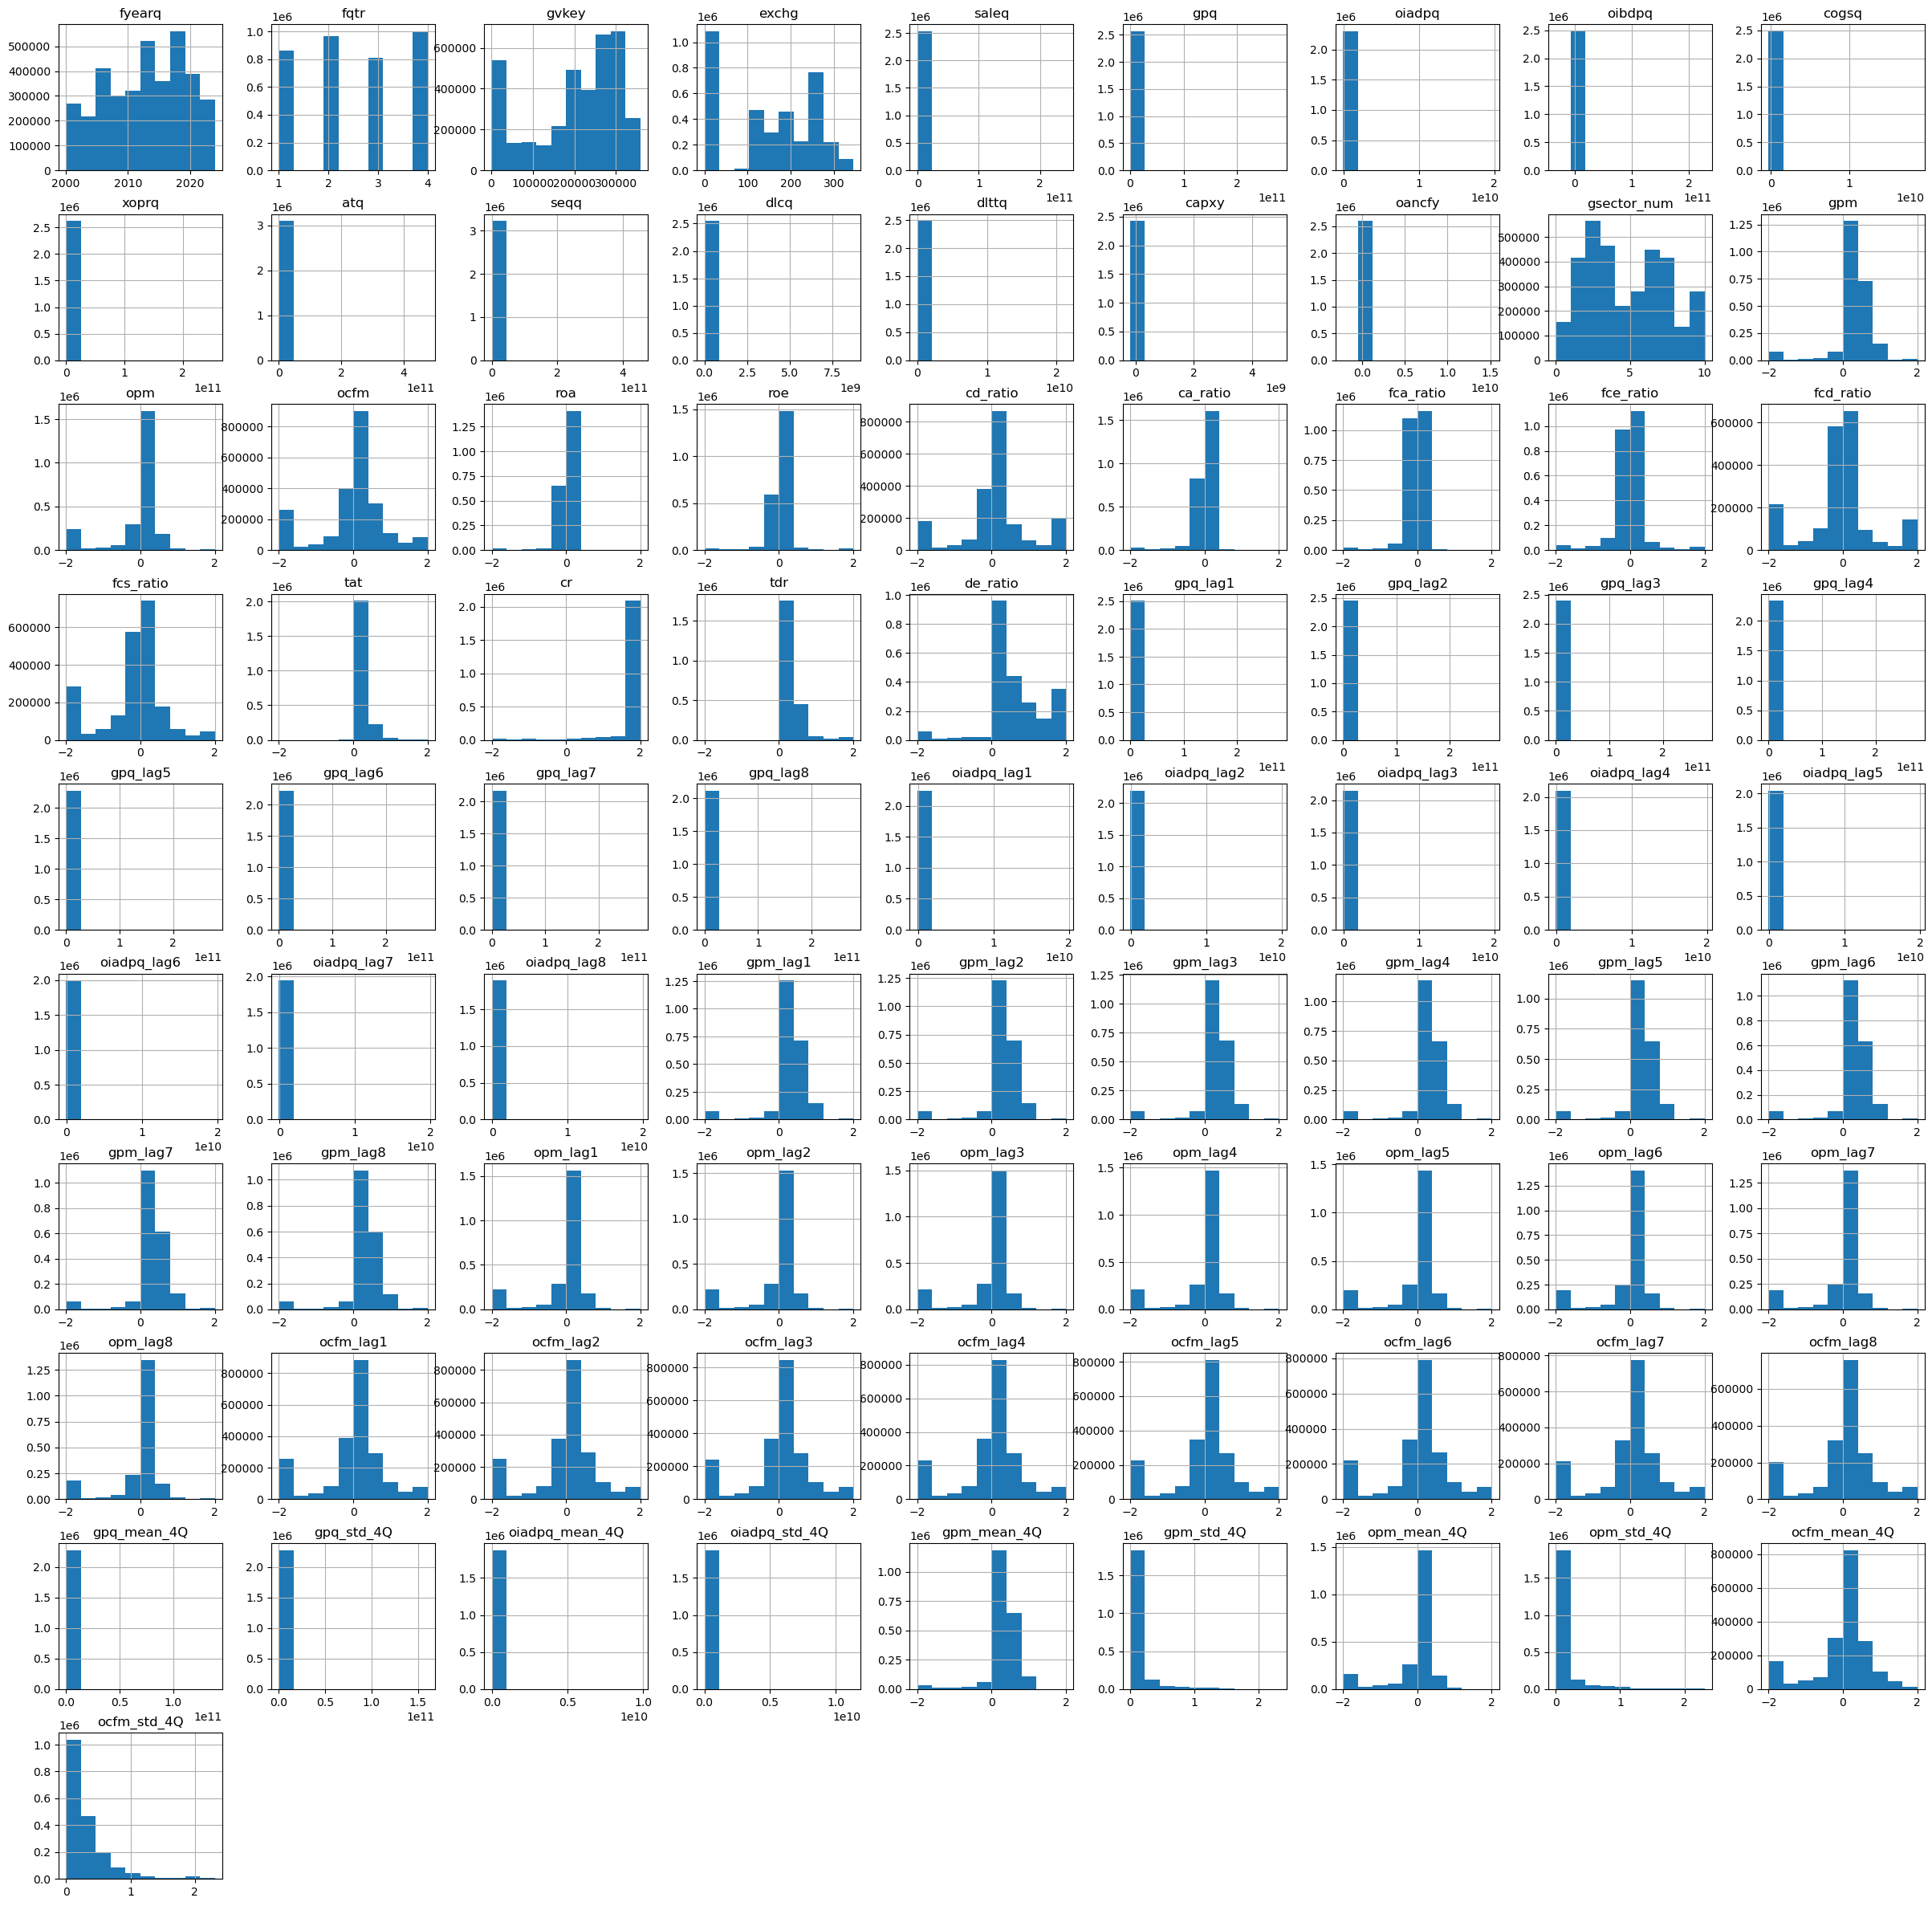

In [72]:
compustat.hist(figsize=(30,30))

## EDA Plots

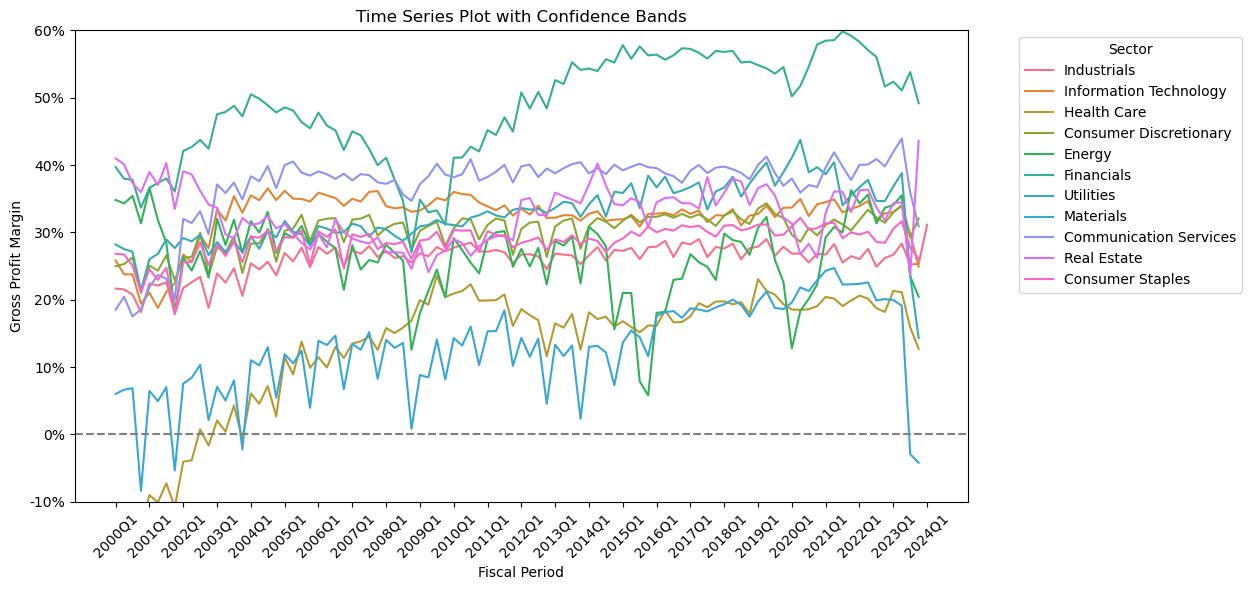

In [73]:
# Create the lineplot with confidence interval
fig1 = plt.figure(figsize=(15, 6))
sns.lineplot(x='datafqtr', y='gpm', hue='gsector', errorbar=None, data=compustat)
plt.axhline(0, color='gray', linestyle='--')

# Add labeling and legends
plt.xlabel('Fiscal Period')
plt.ylabel('Gross Profit Margin')
plt.title('Time Series Plot with Confidence Bands')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(-0.1,0.6)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
xticks = plt.xticks()[0]
plt.xticks(sorted_unique_periods[::4], labels=sorted_unique_periods[::4], rotation=45)
    
# Show the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()
fig1.savefig('../figures/industry_gpm_by_quarter.png', dpi=300)

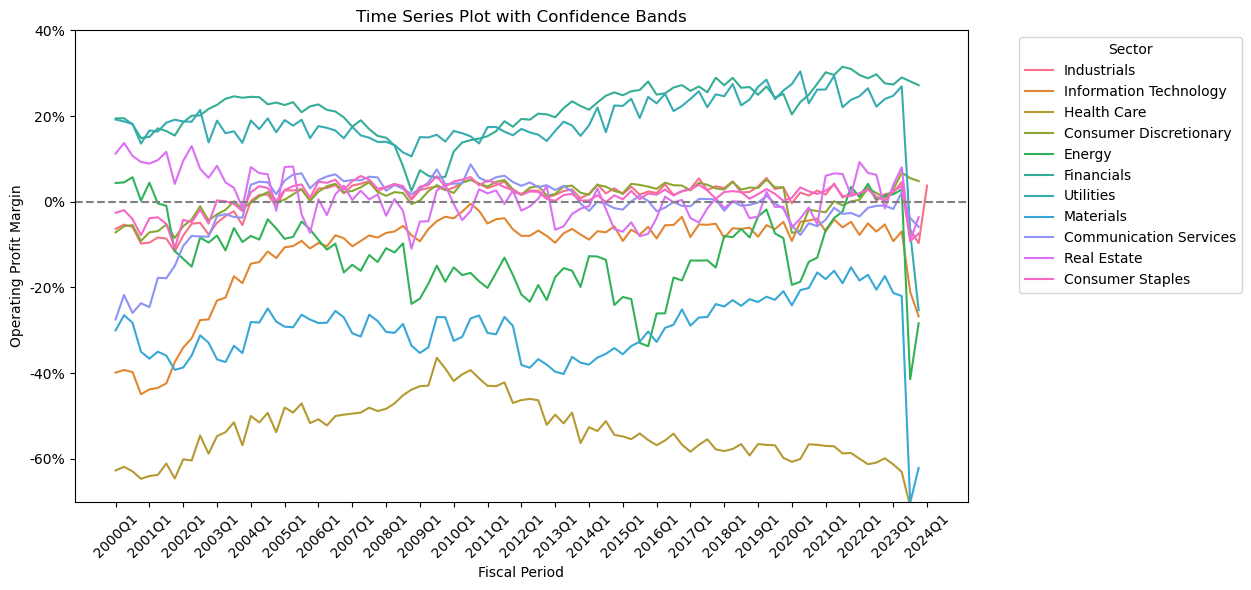

In [74]:
# Create the lineplot with confidence interval
fig2 = plt.figure(figsize=(15, 6))
sns.lineplot(x='datafqtr', y='opm', hue='gsector', errorbar=None, data=compustat)
plt.axhline(0, color='gray', linestyle='--')

# Add labeling and legends
plt.xlabel('Fiscal Period')
plt.ylabel('Operating Profit Margin')
plt.title('Time Series Plot with Confidence Bands')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(-0.7,0.4)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
xticks = plt.xticks()[0]
plt.xticks(sorted_unique_periods[::4], labels=sorted_unique_periods[::4], rotation=45)
    
# Show the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()
fig2.savefig('../figures/industry_opm_by_quarter.png', dpi=300)

In [75]:
import plotly.express as px
import pandas as pd

# Aggregate data by mean
agg_data = compustat.groupby(['datafqtr', 'gsector'])['opm'].mean().reset_index()

# Create the line plot
fig3 = px.line(agg_data, 
              x='datafqtr', 
              y='opm', 
              color='gsector',
              title='Time Series Plot with Confidence Bands')

# Customizations
fig3.update_layout(
    xaxis_title='Fiscal Period',
    yaxis_title='Gross Profit Margin',
    legend_title='Sector',
    yaxis=dict(tickformat=".0%"),
    xaxis=dict(tickvals=sorted_unique_periods[::4], ticktext=sorted_unique_periods[::4])
)

# Add horizontal line at y=0
fig3.add_hline(y=0, line_dash="dash", line_color="gray")

# Adjusting legend position
fig3.update_layout(legend=dict(
    yanchor="top",
    y=1,
    xanchor="left",
    x=1.05
))

# Display the plot
fig3.show()
# save the plot
#fig3.write_image('../figures/industry_opm_by_quarter_plotly.png', width=2000, height=1200)

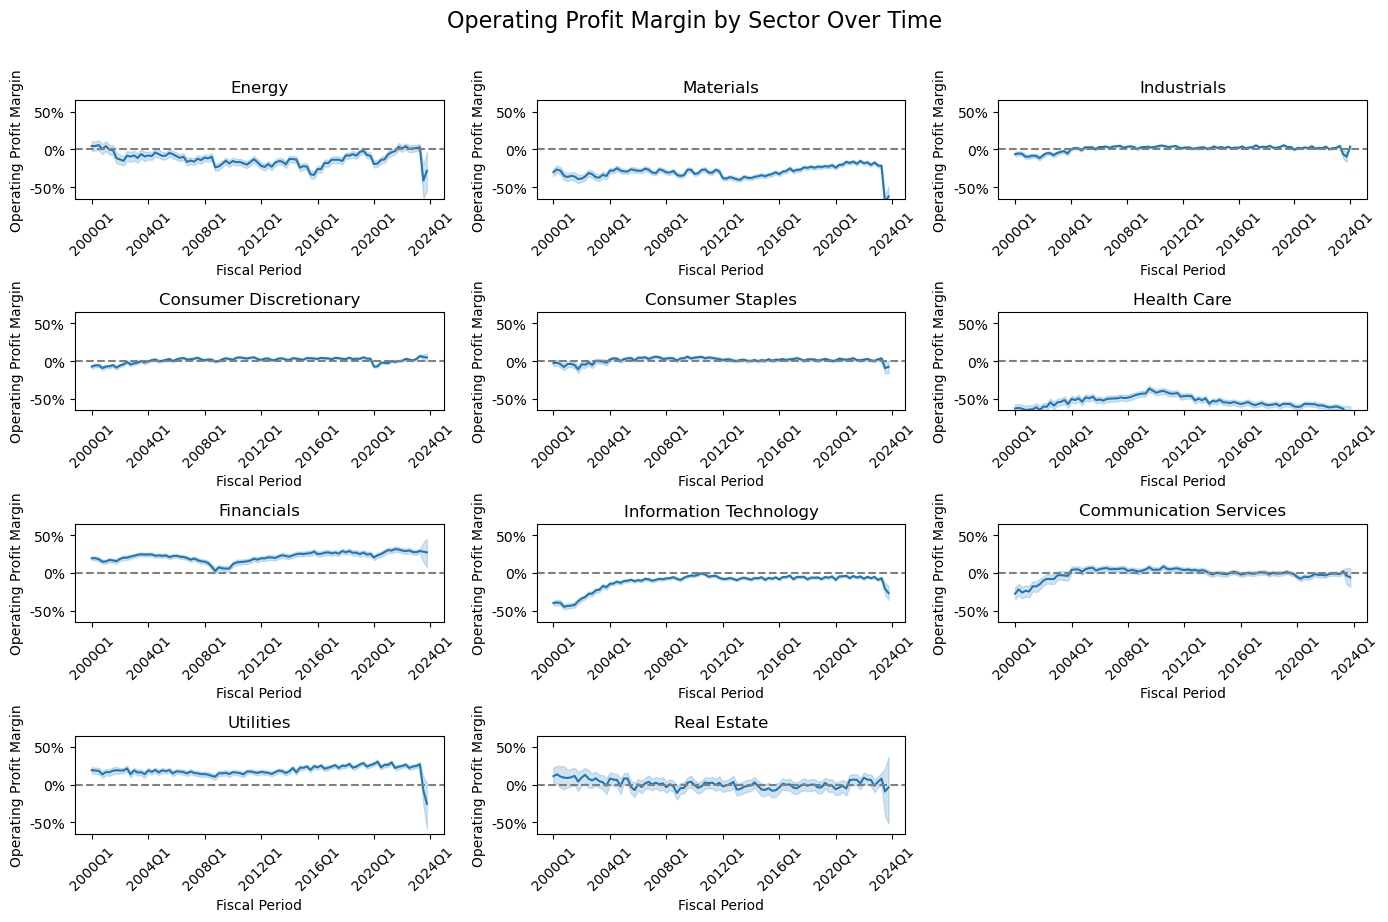

In [76]:
fig4, axes = plt.subplots(4, 3, figsize=(14, 9))
fig4.suptitle('Operating Profit Margin by Sector Over Time', fontsize=16, y=1.02)

# Flatten the axes array for easy indexing
axes = axes.flatten()
xtick_indices = range(0, len(sorted_unique_periods), 16)  # Adjust the step as needed

# Loop through each unique sector to create its own subplot
for i, sector in enumerate(gic_to_sector.values()):
    ax = axes[i]
    sns.lineplot(x='datafqtr', y='opm', data=compustat[compustat['gsector'] == sector], ax=ax)
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_title(sector)
    ax.set_xlabel('Fiscal Period')
    ax.set_ylabel('Operating Profit Margin')
    ax.set_ylim(-0.65, 0.65)

    ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    xticks = ax.get_xticks()
    ax.set_xticks(xtick_indices)
    ax.set_xticklabels(sorted_unique_periods[::16], rotation=45) 
    #ax.set_xticks(sorted_unique_periods_dt[::16])  # Set x-ticks with datetime objects
    #ax.set_xticklabels([label.strftime('%YQ%q') for label in sorted_unique_periods_dt[::16]], rotation=45)
 
# Remove any unused subplots
for i in range(len(gic_to_sector.values()), len(axes)):
    fig4.delaxes(axes[i])

plt.tight_layout()
plt.show()
fig4.savefig('../figures/industry_opm_by_sector.png', dpi=300)

In [ ]:
# Filter the DataFrame for the quarter 2023-Q3
filtered_data = compustat[compustat['datafqtr'] == '2023Q3']

# Melt the DataFrame to have 'metric' and 'value' columns
melted_data = filtered_data.melt(id_vars=['gsector', 'datafqtr'], value_vars=['gpm', 'opm'],
                                 var_name='metric', value_name='value')

# Create the box-and-whisker plot
fig5 = plt.figure(figsize=(12, 5))
sns.boxplot(x='gsector', y='value', hue='metric', data=melted_data, showfliers=False)

# Add labeling and titles
plt.xlabel('Sector')
plt.ylabel('Profit Margin (%)')
plt.title('Box-and-Whisker Plot Comparing Gross and Operating Profit Margins by Sector for 2023-Q3')
plt.axhline(0, color='gray', linestyle='--')

labels = [item.get_text() for item in plt.gca().get_xticklabels()]
new_labels = [label.replace(' ', '\n') for label in labels]
plt.xticks(ticks=plt.xticks()[0], labels=new_labels, rotation=0)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))

plt.tight_layout()
plt.show()
fig5.savefig('../figures/industry_opm_boxplot.png', dpi=300)

In [ ]:
correlation_matrix = compustat.select_dtypes(include=[np.number]).corr()
fig6 = plt.figure(figsize=(20,17))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()
fig6.savefig('../figures/correlation_matrix.png', dpi=300)

In [ ]:
compustat.shape

In [ ]:
compustat['gsector'].value_counts()

In [ ]:
compustat.shape

In [ ]:
compustat.columns

## Splitting & Preprocessing

In [25]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [26]:
year_ftrs = ['fyearq','fqtr']
num_ftrs = ['saleq', 'gpq', 'oiadpq',
       'oibdpq', 'cogsq', 'xoprq', 'atq', 'seqq', 'dlcq', 'dlttq', 'capxy',
       'oancfy', 'gpm', 'opm', 'ocfm', 'roa', 'roe', 'cd_ratio', 'ca_ratio',
       'fca_ratio', 'fce_ratio', 'fcd_ratio', 'fcs_ratio', 'tat', 'cr', 'tdr',
       'de_ratio', 'gpq_lag1', 'gpq_lag2', 'gpq_lag3', 'gpq_lag4', 'gpq_lag5',
       'gpq_lag6', 'gpq_lag7', 'gpq_lag8', 'oiadpq_lag1', 'oiadpq_lag2',
       'oiadpq_lag3', 'oiadpq_lag4', 'oiadpq_lag5', 'oiadpq_lag6',
       'oiadpq_lag7', 'oiadpq_lag8', 'gpm_lag1', 'gpm_lag2', 'gpm_lag3',
       'gpm_lag4', 'gpm_lag5', 'gpm_lag6', 'gpm_lag7', 'gpm_lag8', 'opm_lag1',
       'opm_lag2', 'opm_lag3', 'opm_lag4', 'opm_lag5', 'opm_lag6', 'opm_lag7',
       'opm_lag8', 'ocfm_lag1', 'ocfm_lag2', 'ocfm_lag3', 'ocfm_lag4',
       'ocfm_lag5', 'ocfm_lag6', 'ocfm_lag7', 'ocfm_lag8',
       'gpq_mean_4Q', 'gpq_std_4Q', 'oiadpq_mean_4Q',
       'oiadpq_std_4Q', 'gpm_mean_4Q', 'gpm_std_4Q', 'opm_mean_4Q',
       'opm_std_4Q', 'ocfm_mean_4Q', 'ocfm_std_4Q']
cat_ftrs = ['loc', 'exchg', 'curcdq']


In [27]:

minmax_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', minmax_transformer, year_ftrs),
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

In [28]:
compustat[year_ftrs] = compustat[year_ftrs].astype(str)
compustat[cat_ftrs] = compustat[cat_ftrs].astype(str)
#compustat[num_ftrs] = compustat[num_ftrs].apply(pd.to_numeric, errors='coerce')

In [29]:
groups = compustat['gvkey']
y = compustat['gsector_num']
X = compustat.drop(['gvkey','gsector','gsector_num','datafqtr'], axis=1)

# Remove rows where y is nan
mask = y.notna()
X = X[mask]
y = y[mask]
groups = groups[mask]

In [30]:
X.shape

(3372632, 82)

Referenced this [article](https://towardsdatascience.com/beyond-grid-search-hypercharge-hyperparameter-tuning-for-xgboost-7c78f7a2929d)
to help with hyperparameter tuning for XGBoost.

In [43]:

# parameters to try 
from sklearn.model_selection import ParameterGrid
import xgboost

this_rs=233

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

# create xgboost model and set parameters 
XGB = xgboost.XGBClassifier(objective = "multi:softmax",
                            colsample_bytree = 0.8,
                            subsample = 0.7,
                            learning_rate = 0.3, 
                            reg_alpha = 0.2,
                            reg_lambda = 30,
                            eval_metric = 'mlogloss',
                            missing = np.nan,
                            early_stopping_rounds=150,
                            seed = this_rs)



In [ ]:

#XGB.set_params(**ParameterGrid(param_grid)[0])

gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=this_rs)
for train_val_idx, test_idx in gss.split(X, y, groups):
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
    group_train_val, group_test = groups.iloc[train_val_idx], groups.iloc[test_idx]

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.17, random_state=this_rs)
for train_idx, val_idx in gss2.split(X_train_val, y_train_val, group_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    group_train, group_val = group_train_val.iloc[train_idx], group_train_val.iloc[val_idx]

X_train.shape, X_val.shape, X_test.shape

In [37]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train = preprocessor.transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((2381655, 360), (491086, 360), (499891, 360))

In [44]:
XGB.fit(X_train,y_train, eval_set=[(X_val, y_val)], verbose=True)


[0]	validation_0-mlogloss:2.12784
[1]	validation_0-mlogloss:2.00508
[2]	validation_0-mlogloss:1.92101
[3]	validation_0-mlogloss:1.86076
[4]	validation_0-mlogloss:1.81375
[5]	validation_0-mlogloss:1.77815
[6]	validation_0-mlogloss:1.75106
[7]	validation_0-mlogloss:1.72823
[8]	validation_0-mlogloss:1.70956
[9]	validation_0-mlogloss:1.69346
[10]	validation_0-mlogloss:1.68085
[11]	validation_0-mlogloss:1.66947
[12]	validation_0-mlogloss:1.66051
[13]	validation_0-mlogloss:1.65267
[14]	validation_0-mlogloss:1.64547
[15]	validation_0-mlogloss:1.63909
[16]	validation_0-mlogloss:1.63368
[17]	validation_0-mlogloss:1.62912
[18]	validation_0-mlogloss:1.62474
[19]	validation_0-mlogloss:1.62108
[20]	validation_0-mlogloss:1.61735
[21]	validation_0-mlogloss:1.61346
[22]	validation_0-mlogloss:1.61064
[23]	validation_0-mlogloss:1.60758
[24]	validation_0-mlogloss:1.60472
[25]	validation_0-mlogloss:1.60159
[26]	validation_0-mlogloss:1.59984
[27]	validation_0-mlogloss:1.59832
[28]	validation_0-mlogloss:1.5

ValueError: Feature shape mismatch, expected: 360, got 1

In [45]:

# predict on validation 
y_CV_pred = XGB.predict(X_val)
y_test_pred = XGB.predict(X_test)


In [48]:
print(f1_score(y_test, y_test_pred, average="macro"))
print(precision_score(y_test, y_test_pred, average="macro"))
print(recall_score(y_test, y_test_pred, average="macro"))

0.431915836970882
0.4821895562596477
0.4147417412247739


In [77]:
y_test_pred

array([9, 9, 9, ..., 2, 1, 1], dtype=int32)

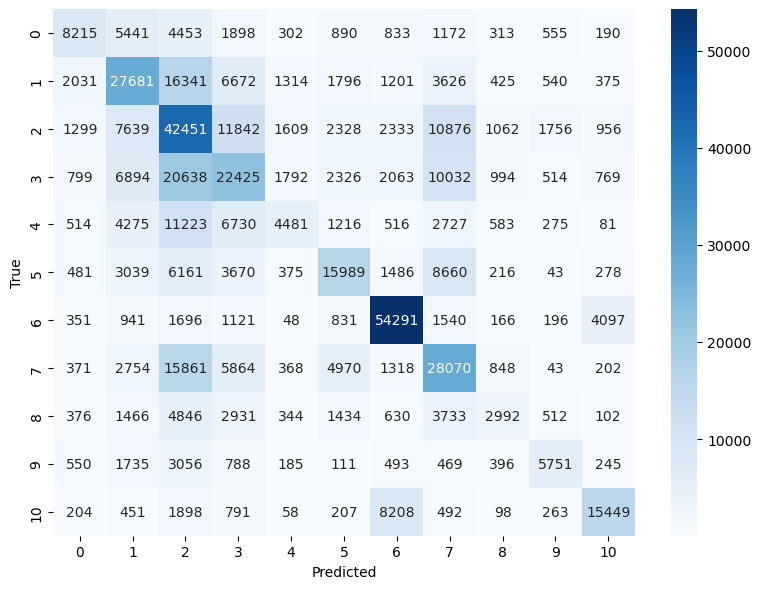

In [53]:


cm = confusion_matrix(y_test, y_test_pred)
# Plotting
plt.figure(figsize=(8, 6), tight_layout=True)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Loop for 5 random states
# in each loop, split, preprocess, fit, and score
random_states = [12, 23, 34, 45, 56]

test_scores = []
models = []

X_test_sets = []
y_test_sets = []

for i in range(1):
    this_rs = random_states[i]

    # Split into [train,val] and test sets (85%, 15%)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=this_rs)
    for train_val_idx, test_idx in gss.split(X, y, groups):
        X_train_val, X_other = X[train_val_idx], X[test_idx]
        y_train_val, y_other = y[train_val_idx], y[test_idx]
        group_train_val, group_other = groups[train_val_idx], groups[test_idx]

    # Split [train,val] into train and val sets (68%, 17%)
    gss_cv = GroupShuffleSplit(n_splits=4, test_size=0.2, random_state=this_rs)

    pipe = make_pipeline(preprocessor, ML_algo)
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='',
                    cv=gss_cv, return_train_score=True, n_jobs=-1, verbose=True)
    #grid.fit(X_train_val, y_train_val)
    #feature_names = preprocessor.get_feature_names_out()

    X_train = preprocessor.fit_transform(X_train)
    X_val = preprocessor.transform(X_val)
    X_test = preprocessor.transform(X_test)
    
    #X_train = pd.DataFrame(data=X_train, columns=feature_names)
    #X_val = pd.DataFrame(data=X_val, columns=feature_names)
    #X_test = pd.DataFrame(data=X_test, columns=feature_names)

    

    # Isolate the XGBoost model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=3,
        learning_rate=0.1,
        n_estimators=1000,
        early_stopping_rounds=10,
        eval_metric='logloss',
        random_state=this_rs
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Make predictions and calculate accuracy on the test set
    y_pred = model.predict(X_test_preprocessed)
    accuracy = accuracy_score(y_test, y_pred)
    print(f1_score(y_test, y_pred, average="macro"))
    print(precision_score(y_test, y_pred, average="macro"))
    print(recall_score(y_test, y_pred, average="macro")
    
    test_scores.append(accuracy)
    models.append(model)

    # You can access the XGBoost model itself using pipeline.named_steps
    # xgb_model = pipeline.named_steps['xgb_model']

In [ ]:
def MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid):
    # Loop for 5 random states
    # in each loop, split, preprocess, fit, and score
    random_states = [12, 23, 34, 45, 56]

    test_scores = []
    models = []

    X_test_sets = []
    y_test_sets = []

    for i in range(5):
        this_rs = random_states[i]

        # Split into [train,val] and test sets (85%, 15%)
        gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=this_rs)
        for train_val_idx, test_idx in gss.split(X, y, groups):
            X_train_val, X_other = X[train_val_idx], X[test_idx]
            y_train_val, y_other = y[train_val_idx], y[test_idx]
            group_train_val, group_other = groups[train_val_idx], groups[test_idx]

        # Split [train,val] into train and val sets (68%, 17%)
        gss_cv = GroupShuffleSplit(n_splits=4, test_size=0.2, random_state=this_rs)

        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring='',
                        cv=gss_cv, return_train_score=True, n_jobs=-1, verbose=True)
        #grid.fit(X_train_val, y_train_val)
        #feature_names = preprocessor.get_feature_names_out()

        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
        X_test = preprocessor.transform(X_test)
        
        #X_train = pd.DataFrame(data=X_train, columns=feature_names)
        #X_val = pd.DataFrame(data=X_val, columns=feature_names)
        #X_test = pd.DataFrame(data=X_test, columns=feature_names)

        

        # Isolate the XGBoost model
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            max_depth=3,
            learning_rate=0.1,
            n_estimators=1000,
            early_stopping_rounds=10,
            eval_metric='logloss',
            random_state=this_rs
        )

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        # Make predictions and calculate accuracy on the test set
        y_pred = model.predict(X_test_preprocessed)
        accuracy = accuracy_score(y_test, y_pred)
        print(f1_score(y_test, y_pred, average="macro"))
        print(precision_score(y_test, y_pred, average="macro"))
        print(recall_score(y_test, y_pred, average="macro")
        
        test_scores.append(accuracy)
        models.append(model)

        # You can access the XGBoost model itself using pipeline.named_steps
        # xgb_model = pipeline.named_steps['xgb_model']

In [ ]:
EARLY_STOPPING_ROUNDS=100  # stop if no improvement after 100 rounds

def my_cv(df, predictors, response, kfolds, regressor, verbose=False):
    """Roll our own CV 
    train each kfold with early stopping
    return average metric, sd over kfolds, average best round"""
    metrics = []
    best_iterations = []

    for train_fold, cv_fold in kfolds.split(df): 
        fold_X_train=df[predictors].values[train_fold]
        fold_y_train=df[response].values[train_fold]
        fold_X_test=df[predictors].values[cv_fold]
        fold_y_test=df[response].values[cv_fold]
        regressor.fit(fold_X_train, fold_y_train,
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      eval_set=[(fold_X_test, fold_y_test)],
                      eval_metric='rmse',
                      verbose=verbose
                     )
        y_pred_test=regressor.predict(fold_X_test)
        metrics.append(np.sqrt(mean_squared_error(fold_y_test, y_pred_test)))
        best_iterations.append(regressor.best_iteration)
    return np.average(metrics), np.std(metrics), np.average(best_iterations)

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
X_test.shape

In [ ]:
X_train.columns

In [ ]:
num_ftrs = ['atq', 'cogsq', 'dlcq', 'dlttq', 'gpq', 'oiadpq',
       'oibdpq', 'saleq', 'seqq', 'unnpq', 'xoprq', 'capxy', 'oancfy',
       'gpm_lag1', 'gpm_lag2', 'gpm_lag3', 'gpm_lag4',
       'opm_lag1', 'opm_lag2', 'opm_lag3', 'opm_lag4']
cat_ftrs = ['loc']

In [ ]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import FeatureUnion


In [ ]:
random_state = 233

# one-hot encoder
# We need to replace the NaN with a string first!
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)
        ])

In [ ]:
#time_tain = X['fiscal_period'] # time
#company_train = train_data['gvkey'] # later group by company
#sector_train = train_data['gsector'] # y, response variable

#X_train = train_data.drop(['fiscal_period','gsector'], axis=1)

In [ ]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# the feature names after fit
feature_names = preprocessor.get_feature_names_out()

# you can convert the numpy array back to a data frame with the feature names if you want
df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)
'''
# transform the CV
df_val = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)
'''

print(feature_names)

In [ ]:
722019/8, 152*8